
# Set up GPU

In [2]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="1,0" # disables GPU to run on CPU
#Used to select graphics card on multiple GPU setup
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True #set to allow dynamic allocation of memory
session = tf.Session(config=config)

# Import packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec
import os
import EELScodes
#dm4reader from https://github.com/jamesra/dm4reader
import dm4reader
import types
import sklearn.model_selection 
import moviepy.video.io.ImageSequenceClip
import copy
import io
import base64
import IPython.display
import keras
import tqdm
import time


Using TensorFlow backend.


# Neural net settings

In [4]:
layer_type='lstm'
size=64
encode_layers=4
decode_layers=4
embedding=16
lr=3e-5
dropout=0.2
l1_norm=1e-4
batch_norm=[True, True]
batch_size=500
epochs=1000

xlimits=[70,140]
maxeV=750
maxeV=(maxeV-300)*2

backgroundregion=np.arange(80,180,1)
activeregion=np.arange(191,205,1)

postfix='_your_postfix_here_'

# Load data

In [5]:
eelsdata='EELS Spectrum Image.dm4'
data=types.SimpleNamespace()

dm4data = dm4reader.DM4File.open(eelsdata)

tags = dm4data.read_directory()
image_data_tag = tags.named_subdirs['ImageList'].unnamed_subdirs[1].named_subdirs['ImageData']
image_tag = image_data_tag.named_tags['Data']
#dimensions are found by examining the tree in the dm4 file, 
#import dm4test.test_dm4 #from the dm4read package
#print(dm4test.test_dm4.print_tag_directory_tree(dm4data, tags, indent_level=0)
dimensions=image_data_tag.named_subdirs['Calibrations'].named_subdirs['Dimension']
# xyscale: this is x or y but thy are expected to be the same, the other can be found at [1]
xyscale=dm4data.read_tag_data(dimensions.unnamed_subdirs[0].named_tags['Scale'])
Escale=dm4data.read_tag_data(dimensions.unnamed_subdirs[2].named_tags['Scale']) # scale in eV
Eorigin=dm4data.read_tag_data(dimensions.unnamed_subdirs[2].named_tags['Origin']) # offset of origin

XDim = dm4data.read_tag_data(image_data_tag.named_subdirs['Dimensions'].unnamed_tags[0])
YDim = dm4data.read_tag_data(image_data_tag.named_subdirs['Dimensions'].unnamed_tags[1])
data.I = np.array(dm4data.read_tag_data(image_tag), dtype=np.uint16)
data.I = np.reshape(data.I, (-1,YDim, XDim))
data.I = np.swapaxes(data.I,0,2)
data.I = np.swapaxes(data.I,0,1)
data.I=data.I[:,:,:maxeV]
shape=data.I.shape

data.E=np.arange(data.I.shape[2])*Escale-Eorigin*Escale
print(data.I.shape)

(146, 228, 900)


# SG-filtering

In [6]:
#1d spectral filter
data.I=EELScodes.savgol(np.float64(np.copy(data.I)), num_to_remove=3, window_length=5, polyorder=3,fit_type='linear')
data.I=data.I.reshape(shape)
#2d filter for each image
tempdata=[]
for i in tqdm.tqdm_notebook(range(data.I.shape[2]), desc="smoothing spectral bands"):
    tempdata.append(EELScodes.sgolay2d(data.I[:,:,i],window_length=5, polyorder=3))
data.I=np.array(tempdata)
data.I = np.swapaxes(data.I,0,2)
data.I = np.swapaxes(data.I,0,1)
print(data.I.shape)


(146, 228, 900)


# Plot image and cut to area of interest

Text(0.5, 1.0, 'Area of interest')

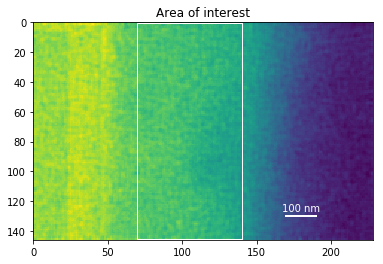

In [7]:
fig= plt.figure(figsize=(12,4))
ax=fig.subplots(1,1)
ax.pcolor(data.I[:,:,0])
ax.axis('scaled')
ax.invert_yaxis()
ax.plot(xlimits,[0.5,0.5],color=[1,1,1,1],lw=1)
ax.plot([xlimits[0],xlimits[0]],[0.5,data.I.shape[0]-0.5],color=[1,1,1,1],lw=1)
ax.plot([xlimits[1],xlimits[1]],[0.5,data.I.shape[0]-0.5],color=[1,1,1,1],lw=1)
ax.plot(xlimits,[data.I.shape[0]-0.5,data.I.shape[0]-0.5],color=[1,1,1,1],lw=1)
#add scale bar!
sbarstartxy=[170,130]
xbarlen=100 #nm
ax.plot([sbarstartxy[0],sbarstartxy[0]+xbarlen*xyscale],[sbarstartxy[1],sbarstartxy[1]],color=[1,1,1,1],lw=2)
ax.text(sbarstartxy[0]+0.5*xbarlen*xyscale,sbarstartxy[1]-3,str(100)+' nm',ha='center',color=[1,1,1,1])
ax.set_title('Area of interest')

In [8]:
data.I=data.I[:,xlimits[0]:xlimits[1],:]

# Backround subtraction based on power law fit of selected region

Text(300, 10000, 'Background subtration based on \nfit to colored region of spectra')

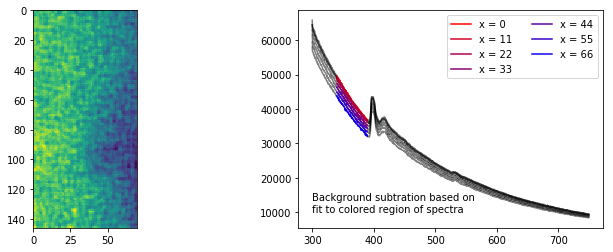

In [9]:
fig= plt.figure(figsize=(12,4))
ax=fig.subplots(1,2)
ax[0].pcolor(data.I[:,:,0])
ax[0].axis('scaled')
ax[0].invert_yaxis()
xlen=data.I.shape[1]
for i in np.arange(0,xlen,xlen//6):
    color=[1*(xlen-i)/xlen,0,1*i/xlen,1]
    DataLineSum=np.sum(data.I[:,i,:], axis=0)
    ax[1].plot(data.E,DataLineSum,color=[0,0,0,0.5])
    DataLineSum=np.sum(data.I[:,i,backgroundregion], axis=0)
    ax[1].plot(data.E[backgroundregion],DataLineSum,color=color,label='x = '+str(i))
ax[1].legend(fontsize=10,ncol=2)
ax[1].text(300,10000,'Background subtration based on \nfit to colored region of spectra')

In [10]:
data.subbed=EELScodes.subtractExpBackground(data.I[:,:,:],backgroundregion)

# Cut data to region of interest

In [ ]:
data.subbedCut=data.subbed[:,:,activeregion]
data.ECut=data.E[activeregion]

In [ ]:
fig= plt.figure(figsize=(12,4))
ax=fig.subplots(1,2)
ax[0].pcolor(data.subbedCut[:,:,0])
ax[0].axis('scaled')
ax[0].invert_yaxis()
xlen=data.I.shape[1]
for i in np.arange(0,xlen,xlen//6):
    color=[1*(xlen-i)/xlen,0,1*i/xlen,1]
    DataLineSum=np.sum(data.subbed[:,i,:], axis=0)
    ax[1].plot(data.E,DataLineSum,color=[0,0,0,0.5])
    DataLineSum=np.sum(data.subbedCut[:,i,:], axis=0)
    ax[1].plot(data.ECut,DataLineSum,color=color,label='x = '+str(i))
ax[0].plot(xlimits,[100,100])
ax[1].legend(fontsize=10,ncol=2)

# Normalize data

In [ ]:
data.subbedCutNorm, data.std, data.mean=EELScodes.normalize(data.subbedCut,extra_output=True)

In [ ]:
fig= plt.figure(figsize=(12,4))
ax=fig.subplots(1,2)
ax[0].pcolor(data.subbedCutNorm[:,:,0])
ax[0].axis('scaled')
ax[0].invert_yaxis()
xlen=data.I.shape[1]
for i in np.arange(0,xlen,xlen//6):
    color=[1*(xlen-i)/xlen,0,1*i/xlen,1]
    DataLineSum=np.sum(data.subbedCutNorm[i,:,:], axis=0)
    ax[1].plot(data.ECut,DataLineSum,color=color,label='x = '+str(i))
ax[0].plot(xlimits,[100,100])
ax[1].legend(fontsize=10,ncol=2)

# Set up NN

In [ ]:
steps=trainingforML.shape[-1]
'''rnn(layer_type, size, encode_layers,
        decode_layers, embedding,
        steps, lr=3e-5, drop_frac=0.,
        bidirectional=True, l1_norm=1e-4,
        batch_norm=[False, False], **kwargs):'''
labelstring='_'.join([layer_type,str(size),str(encode_layers),str(decode_layers)
         ,str(embedding),str(lr),str(dropout)
         ,str(l1_norm),str(batch_norm),str(batch_size)
         ,str(epochs),str(steps)])
labelstring=labelstring.replace(', ','').replace('[','').replace(']','').replace('.','p')+postfix
print(labelstring)

In [ ]:
trainingforML=data.subbedCutNorm

In [ ]:
training=0
if training:
    EELS_model, run_id = EELScodes.rnn(layer_type, size, encode_layers,
                              decode_layers, embedding, steps,
                              lr=lr, drop_frac=dropout, l1_norm=l1_norm,
                              batch_norm=batch_norm)
else:
    EELS_model=keras.models.load_model('./model/start_seed_042.h5')
    EELS_model.load_weights('./model/weights.009319-0.3422.hdf5')
    '''EELS_model=keras.models.load_model(
    'EELSmodels/lstm_64_4_4_16_3e-05_0p2_0p0001_TrueTrue_500_1000_14_testNoValidation_/'
    +'2_14_2019_17h_18m_Bidirect_lstm_size064_enc4_emb16_dec4_lr3m05_drop20_batchnorm_TT/'
    +'start_seed_042.h5')
    EELS_model.load_weights(
    'EELSmodels/lstm_64_4_4_16_3e-05_0p2_0p0001_TrueTrue_500_1000_14_testNoValidation_/'
    +'2_14_2019_17h_18m_Bidirect_lstm_size064_enc4_emb16_dec4_lr3m05_drop20_batchnorm_TT/'
    +'weights.000996.hdf5')'''

# Train Model

In [ ]:
if not os.path.exists('./EELSmodels/'):
    os.mkdir('./EELSmodels/')
model_folder = './EELSmodels/'+labelstring
if not os.path.exists(model_folder):
    os.mkdir(model_folder)
if training:
    # trains the model saving results as checkpoints
    EELScodes.train_model(run_id, EELS_model,
                    trainingforML.reshape((-1,steps)),
                    None, #do not use a validation set
                    model_folder,
                    batch_size=batch_size,
                    epochs=epochs)

In [ ]:
# print location of model and model weights
model_folder = './EELSmodels/'+labelstring
if os.path.exists(model_folder):
    print('possble matches in: '+model_folder+'/')
    for folder in os.listdir(model_folder):
        if  os.path.isdir(model_folder+'/'+folder) and not folder=='movie':
            print('\tsubdirectory: '+folder+'/')
            files=os.listdir(model_folder+'/'+folder)
            print('\t\t model is probably:\n'+model_folder+'/'+folder+'/'+sorted(files)[1])
            print('\t\t weights is probably:\n'+model_folder+'/'+folder+'/'+sorted(files)[-1])
else:
    print('This model has not been run (under this name)')

# Plot maps of embeddings

In [ ]:
embeddings = EELScodes.get_activations(EELS_model,
                                 trainingforML.reshape((-1,steps)),
                                 9)
embeddings=embeddings.reshape((trainingforML.shape[0],trainingforML.shape[1],-1))

In [ ]:
fig= plt.figure(figsize=(12,12))
ax=[]
for i in range(16):
    if np.max(embeddings[:,:,i])>10**-6:
        ax.append(fig.add_subplot(4,4,len(ax)+1))
        pcolor=ax[-1].pcolor(embeddings[:,:,i])
        #pcolor.set_clim(0, 0.001)
        ax[-1].invert_yaxis()
        fig.colorbar(pcolor,ax=ax[-1])
        ax[-1].axis('scaled')
        ax[-1].set_title('Embedding '+str(i))
    
sbarstartxy=[10,130]
xbarlen=100 #nm
ax[0].plot([sbarstartxy[0],sbarstartxy[0]+xbarlen*xyscale],[sbarstartxy[1],sbarstartxy[1]],color=[1,1,1,1],lw=2)
ax[0].text(sbarstartxy[0]+0.5*xbarlen*xyscale,sbarstartxy[1]-3,str(100)+' nm',ha='center',color=[1,1,1,1])
fig.tight_layout()
fig.savefig(model_folder.strip('/')+'.png')

# Use decoder to look at low level embeddings - Single Plot

In [ ]:
decoder=EELScodes.rnn_decoder(EELS_model,decoder_start=10)

In [ ]:
numframes=10

#calculate average embeddings
avgembeddings=np.average(embeddings,axis=(0,1))
#calculate number of nonzero embeddings
comps=[]
for comp in range(embedding):
    if np.max(embeddings[:,:,comp])>10**-6:
        comps.append(comp)
#calculate number of rows in the figure
rows=(len(comps)+3)//4
#set up the figure
fig= plt.figure(figsize=(16,4*rows))
ax=[] # axes for curves
mapax=[] # axes for images (maps)
compsteps=[] # step in component for each frame
avgAmp=[] # average amplitude of each embedding as fractio in the range(0, max(embedding))
i=0
for _,comp in enumerate(comps):
    # make usefull lists
    compsteps.append(np.max(embeddings[:,:,comp])/(numframes-1))
    avgAmp.append(avgembeddings[comp]/np.max(embeddings[:,:,comp]))
    row=i//4
    col=i%4
    rowstep=1/rows
    # make axes
    ax.append(fig.add_axes([0.06+0.24*col, 1-rowstep*(row+1-0.15), 0.18, rowstep*(1-0.28)])) #magical expressions for placement
    mapax.append(fig.add_axes([0.21+0.24*col, 1-rowstep*(row+1-0.63), 0.08, rowstep*(1-0.7)]))
    # plot maps
    pcolor=mapax[-1].pcolor(embeddings[:,:,comp])
    mapax[-1].invert_yaxis()
    mapax[-1].axis('scaled')
    mapax[-1].tick_params(
        axis='both',          # changes apply to the both-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,      # ticks along the left edge are off
        right=False,         # ticks along the right edge are off
        labelbottom=False, # labels along the bottom edge are off
        labelleft=False) # labels along the left edge are offembeddings = EELScodes.get_activations(EELS_model,
    i+=1
sbarstartxy=[30,130]
xbarlen=100 #nm
mapax[0].plot([sbarstartxy[0],sbarstartxy[0]+xbarlen*xyscale],[sbarstartxy[1],sbarstartxy[1]],color=[1,1,1,1],lw=2)
mapax[0].text(sbarstartxy[0]+0.5*xbarlen*xyscale,sbarstartxy[1]-10,str(100)+' nm',ha='center',color=[1,1,1,1])


ylim=[30,75] # desired ylimit of the plot 
barStart=ylim[0]+(ylim[1]-ylim[0])*0.1 # the bars that show magnitude are placed at these locations
barHeight=(ylim[1]-ylim[0])*0.2
barxStart=398 # x location for the bars
barxStep=0.5
for i, comp in tqdm.tqdm_notebook(enumerate(comps),total=len(comps), desc="Embeddings plotted"):
    for j,comp2 in enumerate(comps):
        ax[i].text(398+j/2,ylim[0]+(ylim[1]-ylim[0])*0.05,str(comp2),ha='center') # number under bars
        if not i==j:
            ax[i].plot([barxStart+j*barxStep,barxStart+j*barxStep], # plot the black bars
                       [barStart,barStart+barHeight*avgAmp[j]],
                       color=[0,0,0,1])
    curembeddings=copy.deepcopy(avgembeddings) #make a copy of the average embeddings, so that we do not overwrite them
    for frame in range(numframes):
        curembeddings[comp]=compsteps[i]*frame #adjust the current embedding
        reconstructed = decoder.predict(np.array([curembeddings]))*data.std+data.mean #predict the spectrum. Transform back using the std and mean
        color=[max(0,2*frame/(numframes-1)-1),0,max(0,2*(1-frame/(numframes-1))-1),1] #nice color gradient from blue to red 
        ax[i].plot(data.ECut,reconstructed[0],color=color) #plot the curve
        ax[i].set_ylim(ylim)
        ax[i].set_ylabel('Counts [a.u.]')
        ax[i].set_xlabel('Energy Loss [eV]')    
        ax[i].set_title('Embedding '+str(comp))
        dx=0.3*frame/numframes-0.15 #x shift of the colored bars
        ax[i].plot([barxStart+i*barxStep+dx,barxStart+i*barxStep+dx], # plot the colored bars
                   [barStart,barStart+barHeight*frame/(numframes-1)],
                   color=color,lw=0.5)
        time.sleep(0.001)

fig.savefig(model_folder.strip('/')+'embeddings.png')

# Use decoder to look at low level embeddings - movie

In [ ]:
movie_folder = model_folder+'/movie'
if not os.path.exists(movie_folder):
    os.mkdir(movie_folder)


In [ ]:
avgembeddings=np.average(embeddings,axis=(0,1))
numframes=100
comps=[]
for comp in range(embedding):
    if np.max(embeddings[:,:,comp])>10**-6:
        comps.append(comp)
rows=(len(comps)+3)//4
fig= plt.figure(figsize=(16,4*rows))
ax=[]
mapax=[]

ylim=[30,75]
barStart=ylim[0]+(ylim[1]-ylim[0])*0.1
barHeight=(ylim[1]-ylim[0])*0.2
barxStart=398
barxStep=0.5

compsteps=[]
avgAmp=[]
i=0
for _,comp in enumerate(comps):
    compsteps.append(np.max(embeddings[:,:,comp])/(numframes-1))
    avgAmp.append(avgembeddings[comp]/np.max(embeddings[:,:,comp]))
    row=i//4
    col=i%4
    rowstep=1/rows
    #ax.append(fig.add_subplot(gs[2*i]))
    ax.append(fig.add_axes([0.06+0.24*col, 1-rowstep*(row+1-0.15), 0.18, rowstep*(1-0.28)]))
    mapax.append(fig.add_axes([0.21+0.24*col, 1-rowstep*(row+1-0.63), 0.08, rowstep*(1-0.7)]))
    #mapax.append(fig.add_subplot(gs[2*i+1]))
    pcolor=mapax[-1].pcolor(embeddings[:,:,comp])
    mapax[-1].invert_yaxis()
    #fig.colorbar(pcolor,ax=ax[-1])
    mapax[-1].axis('scaled')
    mapax[-1].tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,      # ticks along the left edge are off
        right=False,         # ticks along the right edge are off
        labelbottom=False, # labels along the bottom edge are off
        labelleft=False) # labels along the left edge are off
    i+=1
sbarstartxy=[30,130]
xbarlen=100 #nm
mapax[0].plot([sbarstartxy[0],sbarstartxy[0]+xbarlen*xyscale],[sbarstartxy[1],sbarstartxy[1]],color=[1,1,1,1],lw=2)
mapax[0].text(sbarstartxy[0]+0.5*xbarlen*xyscale,sbarstartxy[1]-10,str(100)+' nm',ha='center',color=[1,1,1,1])

for frame in tqdm.tqdm_notebook(range(numframes), desc="Generating frames"):
    for i,comp in enumerate(comps):
        ax[i].cla()
        curembeddings=copy.deepcopy(avgembeddings)
        curembeddings[comp]=compsteps[i]*frame
        reconstructed = decoder.predict(np.array([curembeddings]))*data.std+data.mean
        color=[max(0,2*frame/(numframes-1)-1),0,max(0,2*(1-frame/(numframes-1))-1),1]
        ax[i].plot(data.ECut,reconstructed[0],color=color)
        ax[i].set_ylim(ylim)
        ax[i].set_ylabel('Counts [a.u.]')
        ax[i].set_xlabel('Energy Loss [eV]')    
        ax[i].set_title('Embedding '+str(comp))
        for j,comp2 in enumerate(comps):
            if i==j:
                ax[i].plot([barxStart+j*barxStep+dx,barxStart+j*barxStep+dx],
                           [barStart,barStart+barHeight*frame/(numframes-1)],
                           color=color)
            else:
                ax[i].plot([barxStart+j*barxStep,barxStart+j*barxStep],
                           [barStart,barStart+barHeight*avgAmp[j]],
                           color=[0,0,0,1])
            ax[i].text(398+j/2,ylim[0]+(ylim[1]-ylim[0])*0.05,str(comp2),ha='center')
    fig.tight_layout()
    fig.savefig(movie_folder+'/'+str(frame)+'.png')
plt.close()            

fps=numframes/3
comp_folder = movie_folder+'/'+str(comp)
listOfPngFiles=[movie_folder+'/'+str(frame)+'.png' for frame in range(numframes)]
listOfPngFiles=listOfPngFiles+listOfPngFiles[::-1]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(listOfPngFiles, fps=fps)
clip.write_videofile(movie_folder + '/'+'allmovie.mp4', fps=fps)


In [ ]:
#display movie
movie=movie_folder + '/allmovie.mp4'
video = io.open(movie, 'r+b').read()
encoded = base64.b64encode(video)
IPython.display.HTML(data='''<video alt="test" controls loop>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

# Movie with header image

In [ ]:
comp_folder = movie_folder+'/'+str(comp)
listOfPngFiles=[movie_folder+'/'+str(frame)+'.png' for frame in range(numframes)]
listOfPngFiles=[model_folder.strip('/')+'embeddings.png']+listOfPngFiles+listOfPngFiles[::-1]+[model_folder.strip('/')+'embeddings.png']
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(listOfPngFiles, fps=fps)
clip.write_videofile(movie_folder + '/'+'allmovieWithCoverImage.mp4', fps=fps)
movie=movie_folder + '/allmovieWithCoverImage.mp4'
video = io.open(movie, 'r+b').read()
encoded = base64.b64encode(video)
IPython.display.HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

# Difference between embeddings

In [ ]:
first=2
last=7
numframes=10

fig= plt.figure(figsize=(4,4))
ax=fig.add_subplot(1,1,1)
avgembeddings=np.average(embeddings,axis=(0,1))
comps=[]
for comp in range(embedding):
    if np.max(embeddings[:,:,comp])>10**-6:
        comps.append(comp)

ylim=[30,75]
barStart=ylim[0]+(ylim[1]-ylim[0])*0.1
barHeight=(ylim[1]-ylim[0])*0.2
barxStart=398
barxStep=0.5

compstepfirst=np.max(embeddings[:,:,first])/(numframes-1)
compsteplast=np.max(embeddings[:,:,last])/(numframes-1)
for j,comp in enumerate(comps):
    ax.text(398+j/2,ylim[0]+(ylim[1]-ylim[0])*0.05,str(comp),ha='center')
curembeddings=copy.deepcopy(avgembeddings)
for frame in range(numframes):
    curembeddings[first]=compstepfirst*frame
    curembeddings[last]=compsteplast*(numframes-frame-1)
    reconstructed = decoder.predict(np.array([curembeddings]))*data.std+data.mean
    color=[max(0,2*frame/(numframes-1)-1),0,max(0,2*(1-frame/(numframes-1))-1),1]
    ax.plot(data.ECut,reconstructed[0],color=color)
    ax.set_ylim(ylim)
    ax.set_ylabel('Counts [a.u.]')
    ax.set_xlabel('Energy Loss [eV]')    
    ax.set_title('Embedding '+str(first)+' - '+str(last))
    dx=0.3*frame/numframes-0.15
    for j,comp2 in enumerate(comps):
        if comp2==first:
            ax.plot([barxStart+j*barxStep+dx,barxStart+j*barxStep+dx],[barStart,barStart+barHeight*frame/(numframes-1)],color=color,lw=0.5)
        elif comp2==last:
            #ax.plot([barxStart+j*barxStep+dx,barxStart+j*barxStep+dx],[barStart,barStart+barHeight*frame/(numframes-1)],color=color,lw=0.5)
            ax.plot([barxStart+j*barxStep+dx,barxStart+j*barxStep+dx],[barStart,barStart+barHeight*(1-frame/(numframes-1))],color=color,lw=0.5)
        else:
            ax.plot([barxStart+j*barxStep,barxStart+j*barxStep],[barStart,barStart+barHeight*avgAmp[j]],color=[0,0,0,1])
    #fig.tight_layout()
fig.savefig(model_folder.strip('/')+str(first)+'-'+str(last)+'embedding.png')

In [ ]:
avgembeddings=np.average(embeddings,axis=(0,1))

numframes=100
fig= plt.figure(figsize=(4,4))
ax=fig.add_subplot(1,1,1)
comp_folder = movie_folder+'/'+str(first)+'-'+str(last)
if not os.path.exists(comp_folder):
    os.mkdir(comp_folder)
compstepfirst=np.max(embeddings[:,:,first])/(numframes-1)
compsteplast=np.max(embeddings[:,:,last])/(numframes-1)


ylim=[30,75]
barStart=ylim[0]+(ylim[1]-ylim[0])*0.1
barHeight=(ylim[1]-ylim[0])*0.2
barxStart=398
barxStep=0.5

for frame in tqdm.tqdm_notebook(range(numframes), desc="Embeddings plotted"):
    ax.cla()
    curembeddings=avgembeddings
    curembeddings[first]=compstepfirst*frame
    curembeddings[last]=compsteplast*(numframes-frame-1)
    reconstructed = decoder.predict(np.array([curembeddings]))*data.std+data.mean
    color=[max(0,2*frame/(numframes-1)-1),0,max(0,2*(1-frame/(numframes-1))-1),1]
    ax.plot(data.ECut,reconstructed[0],color=color)
    ax.set_ylim([30,75])
    ax.set_ylabel('Counts [a.u.]')
    ax.set_xlabel('Energy Loss [eV]')
    for j,comp2 in enumerate(comps):
        if comp2==first:
            ax.plot([barxStart+j*barxStep,barxStart+j*barxStep],[barStart,barStart+barHeight*frame/(numframes-1)],color=color)
        elif comp2==last:
            ax.plot([barxStart+j*barxStep,barxStart+j*barxStep],[barStart,barStart+barHeight*(1-frame/(numframes-1))],color=color)
        else:
            ax.plot([barxStart+j*barxStep,barxStart+j*barxStep],[barStart,barStart+barHeight*avgAmp[j]],color=[0,0,0,1])
        ax.text(398+j/2,ylim[0]+(ylim[1]-ylim[0])*0.05,str(comp2),ha='center')
    fig.savefig(comp_folder+'/'+str(frame)+'.png')
plt.close()

fps=30
#comp_folder = movie_folder+'/'+str(comp)
listOfPngFiles=[comp_folder+'/'+str(frame)+'.png' for frame in range(numframes)]
listOfPngFiles=listOfPngFiles+listOfPngFiles[::-1]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(listOfPngFiles, fps=fps)
clip.write_videofile(movie_folder + '/'+str(first)+'-'+str(last)+'movie.mp4', fps=fps)

    

In [ ]:
movie=movie_folder + '/'+str(first)+'-'+str(last)+'movie.mp4'
video = io.open(movie, 'r+b').read()
encoded = base64.b64encode(video)
IPython.display.HTML(data='''<video alt="test" controls loop>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

# Movie with header image

In [ ]:
listOfPngFiles=[comp_folder+'/'+str(frame)+'.png' for frame in range(numframes)]
listOfPngFiles=[model_folder.strip('/')+str(first)+'-'+str(last)+'embedding.png'
               ]+listOfPngFiles+listOfPngFiles[::-1]+[
                model_folder.strip('/')+str(first)+'-'+str(last)+'embedding.png']

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(listOfPngFiles, fps=fps)
clip.write_videofile(movie_folder + '/'+str(first)+'-'+str(last)+'movieWithCoverImage.mp4', fps=fps)


movie=movie_folder + '/'+str(first)+'-'+str(last)+'movieWithCoverImage.mp4'
video = io.open(movie, 'r+b').read()
encoded = base64.b64encode(video)
IPython.display.HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))